In [6]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd

In [7]:

data = pd.read_csv('data/KXBTCD-25MAY1400.csv', delimiter=',')
# data = pd.read_csv('data/KXBTCD-25MAY1323.csv', delimiter=',')

# data = pd.read_csv('data/data_log.csv', delimiter=',')

In [10]:
brti_prices = data[data['product'] == 'BRTI'][['timestamp', 'price']]

brti_prices.reset_index(drop=True, inplace=True)

brti_prices['timestamp'] = brti_prices.apply(lambda x: datetime.datetime.fromisoformat(x['timestamp']), axis=1)
brti_prices['timestamp'] = brti_prices['timestamp'].dt.tz_localize('UTC')


start_time = brti_prices['timestamp'].min()

brti_prices.head(5)

,timestamp,price
0,2025-05-14 03:01:39+00:00,103754.47
1,2025-05-14 03:01:40+00:00,103756.77
2,2025-05-14 03:01:41+00:00,103754.31
3,2025-05-14 03:01:43+00:00,103754.77
4,2025-05-14 03:01:44+00:00,103754.14


In [34]:
all_dfs = {}

all_strikes = data['strike'].unique()[1:]

for strike in all_strikes:
    # Filter the data for the specific strike
    strike_df = data[data['strike'] == strike][['timestamp', 'strike', 'bid_1_price', 'ask_1_price', 'expiration_time']]

    underlying_data = brti_prices[['timestamp', 'price']]

    underlying_data.reset_index(drop=True, inplace=True)
    strike_df.reset_index(drop=True, inplace=True)

    strike_df['timestamp'] = pd.to_datetime(strike_df['timestamp'], utc=True)
    strike_df['expiration_time'] = pd.to_datetime(strike_df['expiration_time'], utc=True)

    # find all nan row indexes in expiration time in strike df
    nan_indexes = strike_df[strike_df['expiration_time'].isna()].index
    # find first non-nan row index in expiration time in strike df
    first_non_nan_index = strike_df[strike_df['expiration_time'].notna()].index[0]
    # get the expiration time of the first non-nan row
    expiration_time = strike_df.loc[first_non_nan_index, 'expiration_time']
    # set all nans in expiration time to the expiration time of the first non-nan row
    strike_df.loc[nan_indexes, 'expiration_time'] = expiration_time
    strike_df['tte'] = (strike_df['expiration_time'] - strike_df['timestamp']).dt.total_seconds() / 60 / 60 / 24 / 365 # in years
    strike_df['steps'] = strike_df['tte'] * 365 * 24 * 60 * 60 # in seconds

    merged_df = pd.merge(underlying_data, strike_df, on='timestamp', how='left')
    all_dfs[strike] = merged_df

In [47]:
strike = 103750.0

df = all_dfs[strike]

# filter valid rows
df_valid = df.dropna(subset=['bid_1_price', 'ask_1_price']).copy()

# compute mid price (calibration target)
df_valid['mid_price'] = 0.5 * (df_valid['bid_1_price'] + df_valid['ask_1_price'])

# extract model inputs
spots = df_valid['price'].values
strikes = df_valid['strike'].values
ttes = df_valid['tte'].values  # Already in years — perfect
targets = df_valid['mid_price'].values / 100 # convert to cents

In [48]:
def simulate_heston(S0, v0, mu, kappa, theta, xi, rho, T, dt, N):
    steps = int(T / dt)
    S_paths = np.zeros((steps + 1, N))
    v_paths = np.zeros((steps + 1, N))
    S_paths[0] = S0
    v_paths[0] = v0

    for t in range(1, steps + 1):
        z1 = np.random.normal(size=N)
        z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=N)

        vt = v_paths[t - 1]
        vt_sqrt = np.sqrt(np.maximum(vt, 0))

        v_paths[t] = vt + kappa * (theta - vt) * dt + xi * vt_sqrt * np.sqrt(dt) * z2
        S_paths[t] = S_paths[t - 1] * np.exp((mu - 0.5 * vt) * dt + vt_sqrt * np.sqrt(dt) * z1)

    return S_paths

def price_binary_call(S_paths, strike):
    final_prices = S_paths[-1]
    payoffs = (final_prices > strike).astype(float)
    return payoffs.mean()

In [63]:
def binary_heston_loss(params, N=1000, verbose=False):
    kappa, theta, xi, rho, v0 = params
    mu = 0.0

    total_error = 0
    errors = []

    for strike in all_strikes:
        df = all_dfs[strike]
        # filter valid rows
        df_valid = df.dropna(subset=['bid_1_price', 'ask_1_price']).copy()
        # compute mid price (calibration target)
        df_valid['mid_price'] = 0.5 * (df_valid['bid_1_price'] + df_valid['ask_1_price'])        

        spots = df_valid['price'].values
        strikes = df_valid['strike'].values
        ttes = df_valid['tte'].values  # Already in years — perfect
        targets = df_valid['mid_price'].values / 100

        for i in range(len(spots)):
            S0, K, T = spots[i], strikes[i], ttes[i]
            if T <= 0:
                continue

            # --- Use coarse resolution (e.g., 5 steps per path) ---
            n_steps = min(5, int(T / 1e-6))  # fallback to 1 step if needed
            dt = T / n_steps

            S_paths = simulate_heston(S0, v0, mu, kappa, theta, xi, rho, T, dt, N)
            payoff = (S_paths[-1] > K).astype(float)
            model_price = payoff.mean()

            error = (model_price - targets[i]) ** 2
            total_error += error
            errors.append(error)

    if verbose:
        print(f"[LOSS] loss={total_error:.6f} | kappa={kappa:.3f}, theta={theta:.4f}, xi={xi:.3f}, rho={rho:.3f}, v0={v0:.4f}")
        print(f"        mean_error={np.mean(errors):.6f}, max_error={np.max(errors):.6f}, median_error={np.median(errors):.6f}")

    return total_error


# estimate initial params

In [64]:
df = brti_prices.copy()

# Step 1: Make sure timestamp is datetime and sorted
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

# Step 2: Resample to 1-second intervals and forward-fill missing prices
df = df.resample('1S').ffill()

# Step 3: Compute log returns
df['log_return'] = np.log(df['price']).diff()

# Step 4: Compute rolling realized volatility over a window of seconds
window = 600
seconds_per_year = 365 * 24 * 60 * 60
delta_t = 1 / seconds_per_year

# Annualized rolling standard deviation
df['realized_vol_10min'] = df['log_return'].rolling(window).std() / np.sqrt(delta_t)

df = df.reset_index()

realized_vol_df = df[['timestamp', 'realized_vol_10min']].copy()

df['log_return'] = np.log(df['price']).diff()
df['squared_return'] = df['log_return']**2
span_seconds = 1200  # EMA over 10 minutes = 600s
df['ema_squared_return'] = df['squared_return'].ewm(span=span_seconds, adjust=False).mean()
seconds_per_year = 365 * 24 * 60 * 60
df['ema_realized_vol'] = np.sqrt(df['ema_squared_return']) * np.sqrt(seconds_per_year)

# Use your latest 10-min realized vol as v0
v0 = df['ema_realized_vol'].iloc[-1]**2

# Use the historical median realized vol² as theta
theta = df['ema_realized_vol'].median()**2

# Estimate vol-of-vol as std deviation of realized vol
xi = df['ema_realized_vol'].std()

# Leave kappa as 1.5 unless you estimate autocorrelation
# rho typically in [-0.9, -0.3] — crypto is skewed negative

v0, theta, xi

C:\Users\chris\AppData\Local\Temp\ipykernel_26876\1328471307.py:8: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df = df.resample('1S').ffill()


(0.017424772610315893, 0.031021133684234165, 0.028469096048387613)

In [66]:
from scipy.optimize import minimize

loss_wrapper = lambda p: binary_heston_loss(
    p, verbose=True
)

params0 = [
    1.5,                      # kappa
    theta,                    # theta
    xi,                       # xi
    -0.6,                     # rho
    v0                        # v0
]
bounds = [(0.01, 10), (0.001, 1), (0.01, 2), (-0.99, 0.0), (0.001, 1)]

res = minimize(loss_wrapper, params0, bounds=bounds, method='L-BFGS-B')

[LOSS] loss=72.253793 | kappa=1.500, theta=0.0310, xi=0.028, rho=-0.600, v0=0.0174
        mean_error=0.007590, max_error=0.062500, median_error=0.004624


KeyboardInterrupt: 

In [67]:
calibrated_params = {
    'kappa': 1.543,
    'theta': 0.0309,
    'xi': 0.028,
    'rho': -0.602,
    'v0': 0.0173
}

binary_heston_loss(
    [1.543, 0.0309, 0.028, -0.602, 0.0173],
    N=10000, verbose=True
)

KeyboardInterrupt: 

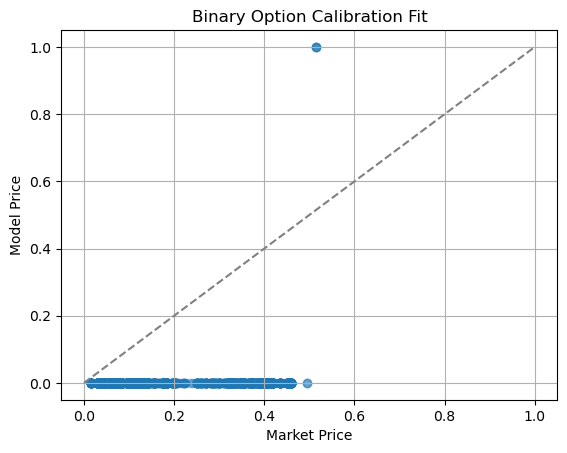

In [70]:
predicted = []
for i in range(len(spots)):
    S_paths = simulate_heston(
        spots[i], 0.0173, 0.0, 1.543, 0.0309, 0.028, -0.602, ttes[i], 5, 5000
    )
    predicted.append((S_paths[-1] > strikes[i]).mean())

plt.scatter(targets, predicted, alpha=0.3)
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("Market Price")
plt.ylabel("Model Price")
plt.title("Binary Option Calibration Fit")
plt.grid(True)
plt.show()
